In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "./../../")

In [3]:
from src import utils
from evaluation import evaluate, get_binary_metric
from training_utils import save_model

In [4]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import random
from torch import optim
from sklearn import metrics
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

In [5]:
# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [6]:
scaler_dict = utils.open_object("./artifacts/feature_scaler.pkl")

In [7]:
config_dict = {}
config_dict['window_size'] = 64
config_dict['learning_rate'] = 0.0001
config_dict['batch_size'] = 12
config_dict['epochs'] = 50
config_dict['device'] = "cuda" if torch.cuda.is_available() else "cpu"
config_dict['input_size'] = 5
config_dict['hidden_size'] = 64
config_dict['output_size'] = 2
config_dict['lstm_num_layers'] = 8
config_dict['dropout'] = 0.2

In [8]:
class Config:
    def __init__(self, dictionary):
        for key, value in dictionary.items():
            setattr(self, key, value)


config = Config(dictionary=config_dict)

### (1) Read Data

In [9]:
df = pd.read_parquet("./artifacts/processed_data.parquet")

In [10]:
df = df.sort_values(by='date').reset_index(drop=True)

In [11]:
df.head()

,date,open,high,low,close,volume
0,1999-11-01,0.481644,0.480709,0.481546,0.479795,0.028304
1,1999-11-02,0.481644,0.480709,0.481156,0.479990,0.071394
2,1999-11-03,0.484156,0.483017,0.485037,0.485023,0.129351
3,1999-11-04,0.489107,0.485494,0.487338,0.487883,0.139565
4,1999-11-05,0.493593,0.490750,0.492627,0.490523,0.096587


In [12]:
# df = df[df['date'] < "2020-01-01"].copy()

In [13]:
df.tail()

,date,open,high,low,close,volume
6066,2023-12-11,0.760372,0.760970,0.761508,0.762955,0.355601
6067,2023-12-12,0.762850,0.762912,0.763376,0.764985,0.348084
6068,2023-12-13,0.765457,0.766479,0.766224,0.768219,0.400896
6069,2023-12-14,0.768859,0.767710,0.767182,0.767997,0.401005
6070,2023-12-15,0.768354,0.767862,0.769231,0.769231,0.420272


### (2) Split the data into train and test sets

In [14]:
features_cols = ["volume", "high", "low", "open", "close"]

df_data = df[features_cols].copy()

In [15]:
df_data.head()

,volume,high,low,open,close
0,0.028304,0.480709,0.481546,0.481644,0.479795
1,0.071394,0.480709,0.481156,0.481644,0.479990
2,0.129351,0.483017,0.485037,0.484156,0.485023
3,0.139565,0.485494,0.487338,0.489107,0.487883
4,0.096587,0.490750,0.492627,0.493593,0.490523


<Axes: >

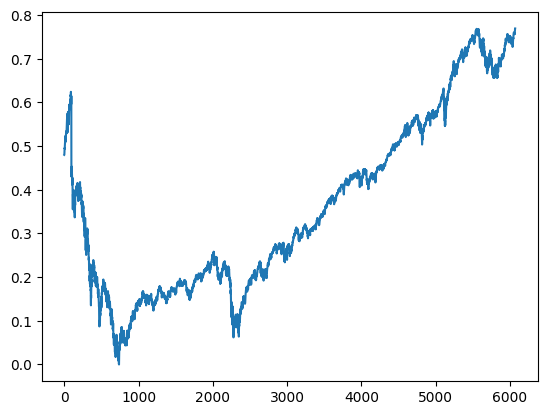

In [16]:
df_data['close'].plot()

In [17]:
train_size = int(0.8 * len(df_data))
df_train = df_data[:train_size]
df_test = df_data[train_size:]

### (3) Create Sequence of input and output

In [18]:
# Custom dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size, target_day=7):
        self.data = data
        self.window_size = window_size
        self.target_day = target_day
        assert self.target_day >= 1

    def __len__(self):
        return len(self.data) - self.window_size - self.target_day

    def __getitem__(self, idx):

        context_window = self.data[idx:idx+self.window_size]
        inputs = torch.tensor(context_window, dtype=torch.float32)

        last_close_price = context_window[-1][-1]
        next_close_price = self.data[idx +
                                     self.window_size+self.target_day-1][-1]

        target = torch.tensor(
            1*(last_close_price < next_close_price), dtype=torch.long)
        return inputs, target

In [19]:
train_dataset = TimeSeriesDataset(
    data=df_train.values, window_size=config.window_size)

In [20]:
test_dataset = TimeSeriesDataset(
    data=df_test.values, window_size=config.window_size)

In [21]:
train_loader = DataLoader(train_dataset, config.batch_size,
                          shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset,
                         config.batch_size, shuffle=False)

In [22]:
for inputs, targets in train_loader:
    break

In [23]:
targets

tensor([1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0])

In [24]:
inputs.shape  # batch_size, sequence_len, features

torch.Size([12, 64, 5])

In [25]:
targets.shape  # batch_size, features

torch.Size([12])

### (4) Modeling

In [26]:
# criterion = nn.MSELoss()

criterion = nn.CrossEntropyLoss()

In [27]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, lstm_num_layers, hidden_size, output_size, device):
        super(BiLSTMModel, self).__init__()
        self.device = device
        self.lstm_num_layers = lstm_num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size,
                            num_layers=lstm_num_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size * 2, input_size)
        self.fc2 = nn.Linear(input_size*2, output_size)

    def forward(self, x):
        h0 = torch.zeros(2*self.lstm_num_layers, x.size(0), self.hidden_size).to(
            self.device)
        c0 = torch.zeros(2*self.lstm_num_layers, x.size(0), self.hidden_size).to(
            self.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc1(out[:, -1, :])
        out = self.fc2(torch.concat([out, x[:, -1, :]], dim=1))

        return out

In [28]:
model = BiLSTMModel(input_size=config.input_size, lstm_num_layers=config.lstm_num_layers,
                    hidden_size=config.hidden_size, output_size=config.output_size,
                    device=config.device)

In [29]:
# x = torch.randn(config.batch_size, config.window_size, config.input_size)

In [30]:
for x, targets in train_loader:
    break

In [31]:
with torch.no_grad():
    outputs = model(x)

In [32]:
criterion(outputs, targets)

tensor(0.6924)

In [33]:
# class self:
#     pass

In [34]:
# input_size = config.input_size
# lstm_num_layers = config.lstm_num_layers
# hidden_size = config.hidden_size
# output_size = config.output_size
# device = config.device

In [35]:
# self.device = device
# self.lstm_num_layers = lstm_num_layers
# self.hidden_size = hidden_size
# self.lstm = nn.LSTM(input_size, hidden_size,
#                     num_layers=lstm_num_layers, batch_first=True, bidirectional=True)
# self.fc = nn.Linear(hidden_size * 2, output_size)
# self.sigmoid = nn.Sigmoid()

In [36]:
# h0 = torch.zeros(2*self.lstm_num_layers, x.size(0), self.hidden_size).to(
#     self.device)
# c0 = torch.zeros(2*self.lstm_num_layers, x.size(0), self.hidden_size).to(
#     self.device)
# out, _ = self.lstm(x, (h0, c0))
# out = self.fc(out[:, -1, :])
# # out = self.sigmoid(out)

In [37]:
# out.shape

In [38]:
# torch.concat([out, x[:, -1, :]], dim=1)

In [39]:
# out[:, -1, :].shape

In [40]:
# x.shape

### (5) Training

In [41]:
result, labels_list, pred_list = evaluate(
    model=model, test_loader=test_loader, criterion=criterion)

Evaluating:: 100%|██████████| 96/96 [00:02<00:00, 35.08it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
result

{'eval_accuracy': 0.3784965034965035,
 'eval_recall': 0.0,
 'eval_precision': 0.0,
 'eval_f1': 0.0,
 'eval_auc': 0.5823791751525841,
 'eval_loss': 0.7250888651857773}

In [43]:
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
best_eval_metrics = -float("inf")
model_version = "v1"
metrics_list = []
best_model_path = None

In [44]:
total_pbar = tqdm(total=len(train_loader)*config.epochs,
                  desc="Training", position=0, leave=True)

for epoch in range(config.epochs):

    loss_list = []
    labels_list = []
    pred_list = []
    prob_list = []

    model = model.train()
    for inputs, targets in train_loader:

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())

        yhat = torch.argmax(outputs, 1).detach().cpu().numpy()
        pred_list.extend(yhat)

        y = targets.detach().cpu().numpy()
        labels_list.extend(y)

        prob = torch.sigmoid(outputs[:, 1])
        prob = prob.detach().cpu().numpy()
        prob_list.extend(prob)

        total_pbar.update(1)

    improve = False
    model_metrics, _, _ = evaluate(
        model, test_loader, criterion)
    eval_metrics = model_metrics['eval_accuracy']

    if eval_metrics >= best_eval_metrics:
        improve = True
        best_checkpoint = epoch
        best_eval_metrics = eval_metrics

    model_metrics['best_eval_accuracy'] = best_eval_metrics
    train_metrics = get_binary_metric(
        labels_list, pred_list, prob_list, train_or_eval="train")
    train_metrics['train_loss'] = np.mean(loss_list)
    model_metrics.update(train_metrics)
    model_metrics["epoch"] = epoch
    model_metrics["best_epoch"] = best_checkpoint
    metrics_list.append(model_metrics)
    # wandb.log(model_metrics)

    if improve:
        save_dir = os.path.join("models", model_version)
        os.makedirs(save_dir, exist_ok=True)
        model_path = save_model(model, save_dir, epoch, model_metrics)
        best_model_path = model_path

    post_fix_message = {k: round(v, 4) for k, v in model_metrics.items()}
    total_pbar.set_postfix(post_fix_message)


total_pbar.close()
# wandb.finish()

Training:   0%|          | 0/19900 [00:00<?, ?it/s]

Training: 100%|██████████| 19900/19900 [43:07<00:00,  7.69it/s, eval_accuracy=0.622, eval_recall=1, eval_precision=0.622, eval_f1=0.767, eval_auc=0.413, eval_loss=0.666, best_eval_accuracy=0.622, train_accuracy=0.565, train_recall=1, train_precision=0.565, train_f1=0.722, train_auc=0.52, train_loss=0.685, epoch=49, best_epoch=11] 


### (6) Validation Model

In [45]:
df_metrics = pd.DataFrame(metrics_list)
df_metrics = df_metrics.set_index("epoch")
df_metrics

,eval_accuracy,eval_recall,eval_precision,eval_f1,eval_auc,eval_loss,best_eval_accuracy,train_accuracy,train_recall,train_precision,train_f1,train_auc,train_loss,best_epoch
epoch,,,,,,,,,,,,,,
0,0.383741,0.015471,0.687500,0.030261,0.581008,0.710075,0.383741,0.542923,0.881306,0.560510,0.685220,0.477512,0.691698,0
1,0.385490,0.026723,0.633333,0.051282,0.580330,0.706313,0.385490,0.554020,0.952098,0.561665,0.706531,0.477181,0.691037,1
2,0.393357,0.059072,0.626866,0.107969,0.580243,0.702350,0.393357,0.557789,0.965863,0.563054,0.711397,0.475033,0.690714,2
3,0.393357,0.060478,0.623188,0.110256,0.579652,0.701710,0.393357,0.563023,0.985523,0.564533,0.717859,0.476919,0.690311,3
4,0.455420,0.213783,0.703704,0.327940,0.578692,0.696216,0.455420,0.563023,0.984787,0.564681,0.717782,0.477328,0.689799,4
5,0.522727,0.419128,0.691415,0.521891,0.578485,0.693343,0.522727,0.564489,0.996660,0.564642,0.720880,0.476009,0.689313,5
6,0.555070,0.627286,0.646377,0.636688,0.577351,0.690574,0.555070,0.563652,0.992958,0.564713,0.719968,0.476806,0.688974,6
7,0.547203,0.579466,0.652932,0.614009,0.577111,0.691522,0.555070,0.563652,0.998515,0.563941,0.720793,0.478259,0.688912,6
8,0.596154,0.801688,0.639731,0.711610,0.575644,0.688723,0.596154,0.563442,0.997774,0.563968,0.720622,0.477602,0.688477,8


<Axes: xlabel='epoch'>

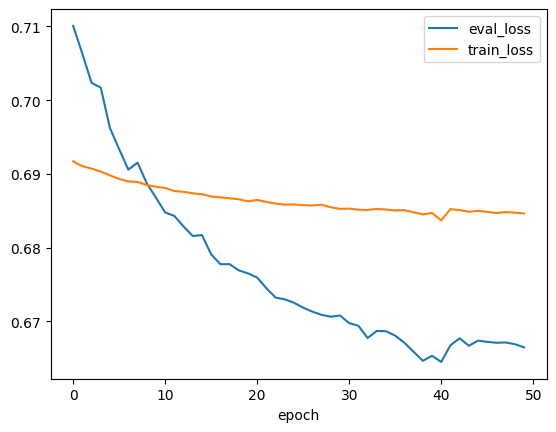

In [46]:
df_metrics[['eval_loss', 'train_loss']].plot()

In [48]:
best_model = BiLSTMModel(input_size=config.input_size, lstm_num_layers=config.lstm_num_layers,
                         hidden_size=config.hidden_size, output_size=config.output_size,
                         device=config.device)

In [49]:
best_model_path

'models/v1/e9dda959-750b-43b8-acbc-cecd90644fcb/checkpoint-11/pytorch_model.pt'

In [50]:
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()
best_model.to(config.device)

BiLSTMModel(
  (lstm): LSTM(5, 64, num_layers=8, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=5, bias=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)

In [57]:
metrics_results, labels_list, pred_list, prob_list = evaluate(
    model=best_model, test_loader=test_loader, criterion=criterion)

Evaluating:: 100%|██████████| 96/96 [00:03<00:00, 28.32it/s]


In [58]:
metrics_results

{'eval_accuracy': 0.6223776223776224,
 'eval_recall': 1.0,
 'eval_precision': 0.6220472440944882,
 'eval_f1': 0.7669902912621359,
 'eval_auc': 0.5698914777027444,
 'eval_loss': 0.6842888897905747}

In [59]:
df_tmp = pd.DataFrame()

In [60]:
df_tmp['prediction'] = pred_list
df_tmp['prob'] = prob_list
df_tmp['real'] = labels_list

In [61]:
df_tmp.tail(20)

,prediction,prob,real
1124,1,0.537890,1
1125,1,0.537465,1
1126,1,0.537967,1
1127,1,0.538018,1
1128,1,0.537538,1
1129,1,0.537999,1
1130,1,0.537743,1
1131,1,0.537535,1
1132,1,0.537550,1
1133,1,0.537468,0
